In [20]:
t = 0
while t < 2
    for i in 1:5
        println("first loop $i")
    end
    for j in 1:6
        println("2nd loop $j")
    end
    t = t + 1
end

first loop 1
first loop 2
first loop 3
first loop 4
first loop 5
2nd loop 1
2nd loop 2
2nd loop 3
2nd loop 4
2nd loop 5
2nd loop 6
first loop 1
first loop 2
first loop 3
first loop 4
first loop 5
2nd loop 1
2nd loop 2
2nd loop 3
2nd loop 4
2nd loop 5
2nd loop 6


In [19]:
using Base.Threads

t = 0
while t < 2
    @threads for i in 1:5
        println("first loop")
          for j in 1:6
            println("2nd loop")
        end
    end
    t = t + 1
end

first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
first loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop
2nd loop


# Rusanov Solver Scalar demo

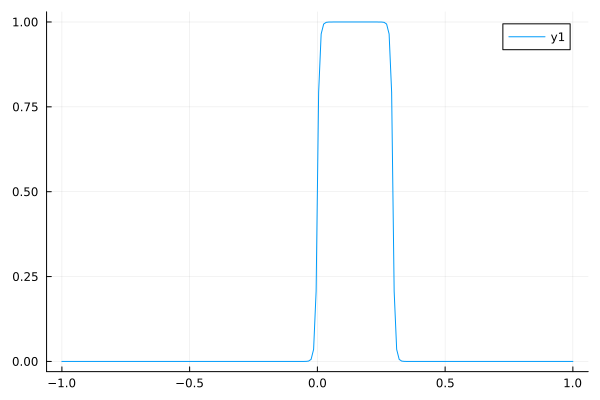

In [15]:
using Plots
# -------- grid & arrays --------
const ng = 2                      # ghost cells
N   = 200                         # interior cells
Nx  = N + 2ng                     # total cells including ghosts
xL, xR = -1.0, 1.0
dx = (xR - xL)/N
x  = range(xL + dx/2, xR - dx/2, length=N)  # interior centers (for ICs/plots)

u  = zeros(Float64, Nx)           # cell-centered solution (with ghosts)
Ff = zeros(Float64, Nx-1)         # face-centered fluxes: Ff[i] = flux at face between i and i+1

# -------- helper: slope limiter (minmod) --------
minmod(a,b) = (sign(a)==sign(b)) ? sign(a)*min(abs(a),abs(b)) : 0.0

# piecewise-linear (PLM) reconstruction slopes per cell
function slopes(u)
    s = similar(u)
    @inbounds for j in 2:length(u)-1
        s[j] = minmod(u[j]-u[j-1], u[j+1]-u[j])
    end
    s[1]   = 0.0;  s[end] = 0.0        # or copy boundary slope rules
    return s
end

# -------- physics for a simple demo (linear advection u_t + a u_x = 0) --------
const a = 1.0
flux(u) = a*u
amax(uL,uR) = abs(a)              # for Rusanov; in SRHD you'd compute max |λ| from states

# Rusanov (LLF) Riemann solver at a face
rusanov(uL,uR) = 0.5*(flux(uL)+flux(uR)) - 0.5*amax(uL,uR)*(uR-uL)

# -------- boundary fill (example: outflow) --------
function fill_bc!(u)
    u[1:ng]        .= u[ng+1]      # left outflow
    u[end-ng+1:end].= u[end-ng]    # right outflow
end

# -------- one Godunov step: Reconstruct -> Riemann -> Update --------
function godunov_step!(u, dt, dx)
    fill_bc!(u)
    s = slopes(u)                  # reconstruction slopes

    # 1) face loop: build left/right states and fluxes at faces
    @inbounds for i in 1:length(u)-1      # face i is between cells i (L) and i+1 (R)
        uL = u[i]   + 0.5*s[i]            # left trace at i+1/2
        uR = u[i+1] - 0.5*s[i+1]          # right trace at i+1/2
        Ff[i] = rusanov(uL,uR)            # or HLLE/HLLC using your wave speeds
    end

    # 2) cell loop: conservative update using face flux difference
    @inbounds for j in ng+1 : length(u)-ng
        u[j] -= (dt/dx) * (Ff[j] - Ff[j-1])  # F_{j+1/2} = Ff[j], F_{j-1/2} = Ff[j-1]
    end
end

# -------- demo initial condition (square pulse) --------
u[ng+1:ng+N] .= (x .≥ -0.4) .& (x .≤ -0.1)         # cell-centered IC on interior
fill_bc!(u)

# -------- time loop --------
CFL = 0.5
t, tf = 0.0, 0.4
while t < tf
    dt = CFL*dx/abs(a)
    if t + dt > tf; dt = tf - t; end
    godunov_step!(u, dt, dx)
    t += dt
end
x_list = range(-1,1,length(u))
plot(x_list,u)

# HLLE Scalar Demo

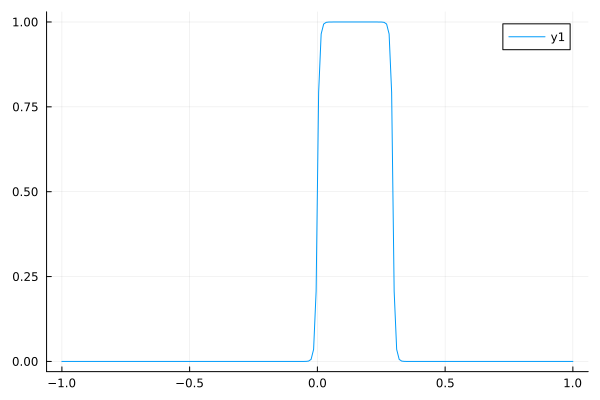

In [14]:
# -------- grid & arrays --------
const ng = 2
N   = 200
Nx  = N + 2ng
xL, xR = -1.0, 1.0
dx = (xR - xL)/N
x  = range(xL + dx/2, xR - dx/2, length=N)

u  = zeros(Float64, Nx)       # cell-centered (with ghosts)
Ff = zeros(Float64, Nx-1)     # face-centered fluxes; face i is between cells i and i+1

# -------- slope limiter --------
minmod(a,b) = (sign(a)==sign(b)) ? sign(a)*min(abs(a),abs(b)) : 0.0
function slopes(u)
    s = similar(u)
    @inbounds for j in 2:length(u)-1
        s[j] = minmod(u[j]-u[j-1], u[j+1]-u[j])
    end
    s[1]=0.0; s[end]=0.0
    return s
end

# -------- physics: u_t + a u_x = 0 --------
const a = 1.0
flux(u) = a*u

# HLLE solver: works for scalars and vectors
hlle(UL, UR, FL, FR, λL, λR) = (λL ≥ 0)  ? FL :
                               (λR ≤ 0)  ? FR :
                               (λR*FL - λL*FR + λL*λR*(UR - UL)) / (λR - λL)

# For advection, characteristic speed is just a (same on both sides)
wavespeeds_advection(uL,uR) = (min(0.0,a), max(0.0,a))

# -------- boundary fill (outflow) --------
function fill_bc!(u)
    u[1:ng]        .= u[ng+1]
    u[end-ng+1:end].= u[end-ng]
end

# -------- one Godunov step with HLLE --------
function godunov_step_hlle!(u, dt, dx)
    fill_bc!(u)
    s = slopes(u)

    # 1) faces: reconstruct L/R traces and compute HLLE fluxes
    @inbounds for i in 1:length(u)-1
        uL = u[i]   + 0.5*s[i]      # left trace at face i+1/2
        uR = u[i+1] - 0.5*s[i+1]    # right trace at face i+1/2
        λL, λR = wavespeeds_advection(uL,uR)
        FL, FR = flux(uL), flux(uR)
        Ff[i] = hlle(uL, uR, FL, FR, λL, λR)
    end

    # 2) cells: conservative update using face flux difference
    @inbounds for j in ng+1 : length(u)-ng
        u[j] -= (dt/dx) * (Ff[j] - Ff[j-1])   # F_{j+1/2}=Ff[j], F_{j-1/2}=Ff[j-1]
    end
end

# -------- IC & time loop --------
u[ng+1:ng+N] .= (x .≥ -0.4) .& (x .≤ -0.1)
fill_bc!(u)

CFL = 0.5
t, tf = 0.0, 0.4
cmax = abs(a)                    # max |wave speed|
while t < tf
    dt = CFL*dx/cmax
    if t + dt > tf; dt = tf - t; end
    godunov_step_hlle!(u, dt, dx)
    t += dt
end
plot(x_list,u)

# HLLC Scalar (For scalar no contact discontinuity)

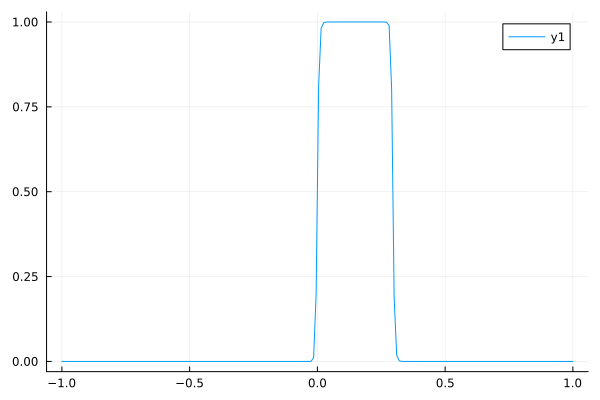

In [18]:
# ============ grid & arrays ============
const ng = 2
N   = 200
Nx  = N + 2ng
xL, xR = -1.0, 1.0
dx = (xR - xL)/N
x  = range(xL + dx/2, xR - dx/2, length=N)

u  = zeros(Float64, Nx)    # cell-centered (with ghosts)
Ff = zeros(Float64, Nx-1)  # face-centered fluxes F_{i+1/2} → Ff[i]

# ============ slope-limited PLM ============
minmod(a,b) = (sign(a)==sign(b)) ? sign(a)*min(abs(a),abs(b)) : 0.0
function slopes(u)
    s = similar(u)
    @inbounds for j in 2:length(u)-1
        s[j] = minmod(u[j]-u[j-1], u[j+1]-u[j])
    end
    s[1]=0.0; s[end]=0.0
    return s
end

# ============ physics: linear advection u_t + a u_x = 0 ============
const a = 1.0
flux(u) = a*u

# "HLLC" for a scalar: this *is* HLLE since there's only one characteristic
# For linear advection, S_L = min(0,a), S_R = max(0,a) and the flux reduces to upwind.
hllc_scalar_flux(uL, uR) = begin
    SL = min(0.0, a)
    SR = max(0.0, a)
    FL, FR = flux(uL), flux(uR)

    if SL ≥ 0.0
        return FL                    # all waves → right: pure left/upwind flux
    elseif SR ≤ 0.0
        return FR                    # all waves ← left: pure right/upwind flux
    else
        # middle speed S_* would be 'a' for linear advection; with a single wave
        # HLLC reduces to HLLE (two-signal) which here equals upwind anyway.
        return (SR*FL - SL*FR + SL*SR*(uR - uL)) / (SR - SL)
    end
end

# ============ boundary conditions (outflow) ============
function fill_bc!(u)
    u[1:ng]        .= u[ng+1]
    u[end-ng+1:end].= u[end-ng]
end

# ============ one Godunov step with "HLLC" (scalar) ============
function godunov_step_hllc_scalar!(u, dt, dx)
    fill_bc!(u)
    s = slopes(u)

    # faces: reconstruct L/R traces → flux at i+1/2 stored in Ff[i]
    @inbounds for i in 1:length(u)-1
        uL = u[i]   + 0.5*s[i]
        uR = u[i+1] - 0.5*s[i+1]
        Ff[i] = hllc_scalar_flux(uL, uR)
    end

    # cells: conservative update using face flux difference
    @inbounds for j in ng+1 : length(u)-ng
        u[j] -= (dt/dx) * (Ff[j] - Ff[j-1])   # F_{j+1/2}=Ff[j], F_{j-1/2}=Ff[j-1]
    end
end

# ============ demo IC & time loop ============
# square pulse in the interior
u[ng+1:ng+N] .= (x .≥ -0.4) .& (x .≤ -0.1)
fill_bc!(u)

CFL = 0.6
t, tf = 0.0, 0.4
cmax = abs(a)
while t < tf
    dt = CFL*dx/cmax
    if t + dt > tf; dt = tf - t; end
    godunov_step_hllc_scalar!(u, dt, dx)
    t += dt
end
plot(x_list,u)